In [18]:
import numpy as np
import random 
import scipy
import matplotlib.pyplot as plt
from random import shuffle
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import time

#### Utils 

In [6]:
def generate_markov_seq(n_states, transition_matrix, len_seq, init_state=None):
    states = [k for k in range(n_states)]
    seq = []
    if init_state:
        x0 = init_state
    else:
        x0 = np.random.choice(states) #add initial probabilities
    x_prev = x0
    seq.append(x_prev)
    for i in range(len_seq):
        x_succ = np.where(np.random.multinomial(1, transition_matrix[x_prev, :], size=1) == 1)[1][0]
        seq.append(x_succ)
        x_prev = x_succ
    return seq

def generate_transtion_matrix(n_states):
    mat = []
    for k in range(n_states):
        row = np.random.random(n_states)
        row = row / np.sum(row)
        mat.append(list(row))
    return np.array(mat)

def generate_series(hidden_seq, params):
    T = len(hidden_seq)
    y = []
    for t in range(T):
        mu_step = params[hidden_seq[t]][0]
        sigma_step = params[hidden_seq[t]][1]
        y.append(np.random.normal(mu_step, sigma_step))
    return y

#### Bayesian hmm object

In [50]:
class bayesian_hmm:
    def __init__(self, prior_params, prior_transitions, n_iter_gibbs, class_label=None):
        self.prior_params = prior_params
        self.prior_transitions = prior_transitions
        self.n_iter_gibbs = n_iter_gibbs
        self.class_label = class_label
    
    def normal_pdf(self, x, mu, sigma):
        return np.exp(-(x - mu)**2/(2*sigma))/(np.sqrt(2*np.pi)*sigma)
    
    def update_prior_dirichlet(self, prior, hidden_seq_obs):
        states = list(set(hidden_seq_obs))
        states.sort()
        n_states = len(states)
        T = len(hidden_seq_obs)
        posterior = prior.copy()
        for h in range(1, T):
            current = hidden_seq_obs[h]
            prev = hidden_seq_obs[h-1]
            posterior[prev, current] += 1
        return posterior

    def dirichlet_expectation(self, mat):
        row_sums = mat.sum(axis=1)
        return mat / row_sums[:, np.newaxis]
    
    def update_prior_gaussian(self, prior, y, n_iter):
        #gibbs sampling
        mu_prior, n0_prior, alpha, beta = prior[0], prior[1], prior[2], prior[3]
        y_bar = np.mean(y)
        ssy = np.sum(np.square(np.array(y) - y_bar))
        n = len(y)
        mu_posteriors = [mu_prior]
        sigma_posteriors = []
        for k in range(n_iter):
            sigma_step = np.random.gamma(alpha + n/2, 1/(beta + 0.5*ssy + (n*n0_prior/(2*(n+n0_prior))) * (y_bar - mu_prior)**2))
            mu_step = np.random.normal((n/(n + n0_prior)) * y_bar + (n0_prior/(n + n0_prior)) * mu_prior, np.sqrt((n+n0_prior)/sigma_step))
            mu_posteriors.append(mu_step)
            sigma_posteriors.append(sigma_step)
        estimator_mu = np.mean(mu_posteriors)
        estimator_sigma = np.mean(sigma_posteriors)
        return estimator_mu, np.sqrt(1/estimator_sigma)
    
    def fit_one_obs(self, y, labels, prior_params, prior_transitions, n_iter_gibbs):
        a = self.update_prior_dirichlet(prior_transitions, labels)
        P_hat = self.dirichlet_expectation(a)
        states = set(labels)
        params_hat = {}
        for s in states:
            y_s = y[np.where(np.array(labels) == s)]
            params_hat[s] = self.update_prior_gaussian(prior_params[s], y_s, n_iter_gibbs)
        return P_hat, params_hat
    
    def fit(self, Y):
        prior_transition = self.prior_transitions
        prior_params = self.prior_params
        n_iter_gibbs = self.n_iter_gibbs
        for obs in Y:
            y_obs, hidden_seq_obs = obs[0], obs[1]
            fit = self.fit_one_obs(y_obs, hidden_seq_obs, prior_params, prior_transition, n_iter_gibbs)
            for s in prior_params:
                prior_params[s][0], prior_params[s][1] = fit[1][s][0], fit[1][s][1]
            prior_transition = fit[0]
        self.posterior_P, self.posterior_params = prior_transition, prior_params
        print("Model fitted")
    
    def emission_proba_viterbi(self, y, P_hat, params_hat):
        n_states = P_hat.shape[0]
        B = np.zeros((n_states, len(y)))
        for s in range(B.shape[0]):
            mu_s = params_hat[s][0]
            sigma_s = params_hat[s][1]
            for t in range(B.shape[1]):
                o_t = y[t]
                B[s, t] = self.normal_pdf(o_t, mu_s, sigma_s)
        return B
    
    def viterbi(self, y, A, B, Pi=None):
        """Slightly modified version of viterbi algorithm from wikipedia
        to suits our needs."""
        # Cardinality of the state space
        K = A.shape[0]
        # Initialize the priors with default (uniform dist) if not given 
        Pi = Pi if Pi is not None else np.full(K, 1 / K)
        T = len(y)
        T1 = np.empty((K, T), 'd')
        T2 = np.empty((K, T), 'B')

        # We take the log of the probabilities to avoid vanishing proba - underflow
        T1[:, 0] = np.log(Pi) + np.log(B[:, 0])
        T2[:, 0] = 0
        # Iterate throught the observations updating the tracking tables
        for i in range(1, T):
            T1[:, i] = np.max(T1[:, i - 1] + np.log(A.T) + np.log(B[np.newaxis, :, i].T), 1)
            #print(T1[:, i - 1] * A.T * B[np.newaxis, :, i].T)
            T2[:, i] = np.argmax(T1[:, i - 1] + np.log(A.T), 1)

        # Build the output, optimal model trajectory
        x = np.empty(T, 'B')
        x[-1] = np.argmax(T1[:, T - 1])
        for i in reversed(range(1, T)):
            x[i - 1] = T2[x[i], i]

        return x, T1[0] 
    
    def likelihood(self, new_series):
        try: 
            self.posterior_P 
        except:
            raise Exception("Need to call fit before likelihood")
            
        B = self.emission_proba_viterbi(new_series, self.posterior_P, self.posterior_params)
        _, probas = self.viterbi(new_series, self.posterior_P, B)
        return probas[-1]
     

### Case with multiple series Training and Testing Set

#### Classification with 3 classes in a well-specified setting: 

- Class 1 : 
    3 States : 
               0 -> N(2,2)
               1 -> N(3,1)
               2 -> N(0,1)
               
- Class 2 : 
    3 States : 
               0 -> N(4,2)
               1 -> N(3,2)
               2 -> N(2,2)
               
- Class 3 : 
    3 States : 
               0 -> N(5,3)
               1 -> N(3,1)
               
And differents probability transitions for each class. 

In [86]:
def generate_samples(n_sample, lengths_range, P, params, init_state=None):
    Y = []
    for sample in range(n_sample):
        n_states = P.shape[0]
        T = np.random.randint(lengths_range[0], lengths_range[1])
        hidden_seq = generate_markov_seq(n_states, P, T, init_state) #hidden states sequence 
        y = generate_series(hidden_seq, params) #time series following HMM model with hidden states and params
        y = np.array(y) + np.random.random(len(y)) * 0.3 #adding noise to series
        Y.append((y, hidden_seq))
    return Y

In [89]:
#Class 1 
n_c1 = 35
P1 = generate_transtion_matrix(3) #random transition matrix with 3 states
params1 = {0: [2, 2], 1 : [3, 1], 2: [0, 1]} #state : [mu, sigma]
len_range1 = [30, 100]
Y1 = generate_samples(n_c1, len_range1, P1, params1)

In [90]:
#class 2
n_c2 = 30
P2 = generate_transtion_matrix(3) #random transition matrix with 3 states
params2 = {0: [4, 2], 1 : [3, 2], 2: [2, 2]} #state : [mu, sigma]
len_range2 = [30, 100]
Y2 = generate_samples(n_c2, len_range2, P2, params2)

In [91]:
#class 3 
n_c3 = 40
P3 = generate_transtion_matrix(2) #random transition matrix with 2 states
params3 = {0: [5, 3], 1 : [0, 4]} #state : [mu, sigma]
len_range3 = [30, 100]
Y3 = generate_samples(n_c3, len_range3, P3, params3)

In [92]:
shuffle(Y1)
shuffle(Y2)
shuffle(Y3)
Test_set = Y1[-10:] + Y2[-7:] + Y3[-9:]
X_test = [ele[0] for ele in Test_set]
Test_label = [1 for x in range(10)] + [2 for x in range(7)] + [3 for x in range(9)]
Y1 = Y1[:-5]
Y2 = Y2[:-6]
Y3 = Y3[:-4]

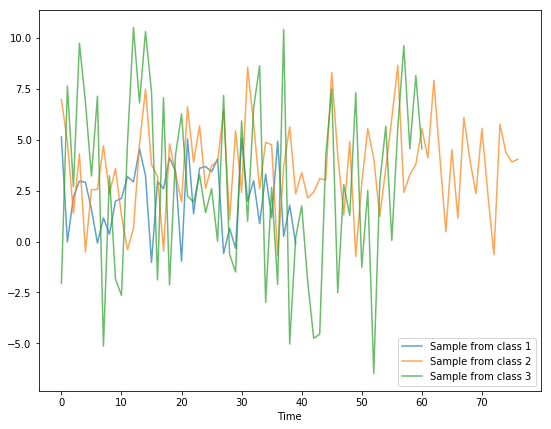

In [93]:
plt.figure(figsize=(9, 7))
plt.plot(Y1[0][0], label="Sample from class 1", alpha=0.7)
plt.plot(Y2[0][0], label="Sample from class 2", alpha=0.7)
plt.plot(Y3[0][0], label="Sample from class 3", alpha=0.7)
plt.legend(loc='best')
plt.xlabel("Time")
plt.show()

#### Training one HMM per class on the training set

In [94]:
#Class 1 
prior_transition1 = np.ones((3, 3)) #prior on transition matrix dirichlet parameter matrix
prior_params1 = {0: [1, 2, 1, 2],
                1: [1, 2, 1, 2],
                2: [1, 2, 1, 2]} #prior parameters for normal gamma prior (shared accross states because no particular prior
#knowledge is assumed for now). 
n_iter_gibbs = 10000 #number of iteration in gibbs sampling method to estimate parameters.

In [95]:
model_class1 = bayesian_hmm(prior_params1, prior_transition1, n_iter_gibbs, class_label=1)
%time model_class1.fit(Y1)

Model fitted
Wall time: 17.4 s


In [96]:
#Class 2
prior_transition2 = np.ones((3, 3)) #prior on transition matrix dirichlet parameter matrix
prior_params2 = {0: [1, 2, 1, 2],
                1: [1, 2, 1, 2],
                2: [1, 2, 1, 2]} #prior parameters for normal gamma prior (shared accross states because no particular prior
#knowledge is assumed for now). 
n_iter_gibbs = 10000 #number of iteration in gibbs sampling method to estimate parameters.

In [97]:
model_class2 = bayesian_hmm(prior_params2, prior_transition2, n_iter_gibbs, class_label=2)
%time model_class2.fit(Y2)

Model fitted
Wall time: 15.1 s


In [98]:
#Class 3
prior_transition3 = np.ones((2, 2)) #prior on transition matrix dirichlet parameter matrix
prior_params3 = {0: [1, 2, 1, 2],
                1: [1, 2, 1, 2]} #prior parameters for normal gamma prior (shared accross states because no particular prior
#knowledge is assumed for now). 
n_iter_gibbs = 10000 #number of iteration in gibbs sampling method to estimate parameters.

In [99]:
model_class3 = bayesian_hmm(prior_params3, prior_transition3, n_iter_gibbs, class_label=3)
%time model_class3.fit(Y3)

Model fitted
Wall time: 14.1 s


### Classifying new observations 

In [100]:
#predict function using only 3 previous models
def assign_classes(series, models):
    """ models must be a list of bayesian_hmm fitted object"""
    predicted_labels = []
    for new_series in series:
        probas = []
        for m in models:
            probas.append((m.likelihood(new_series), m.class_label))
        probas = sorted(probas, key=lambda x : x[0])
        predicted_labels.append(probas[-1][1])
    return predicted_labels

In [101]:
predictions = assign_classes(X_test, [model_class1, model_class2, model_class3])

In [102]:
def get_acc(true, preds):
    return np.sum(np.array(true) == np.array(preds)) / len(true)

In [103]:
acc = get_acc(Test_label, predictions)
acc

0.9615384615384616

In [104]:
conf = confusion_matrix(Test_label, predictions)

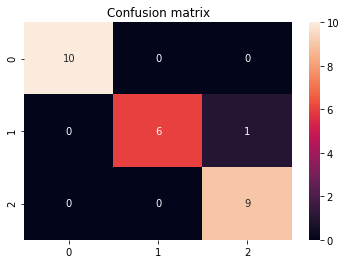

In [105]:
plt.title("Confusion matrix")
sns.heatmap(conf, annot=True)
plt.show()

#### Classification in a mis specified setting 

We simulate groups of time series according to the following process : Pour l'instant j'en ai fais qu'une pour voir 

- Class 1 : State : 
                  0 : AR(1)
                  1 : AR(3)
- Class 2 : State :
                  0 : AR(2)
                  1 : AR(4)

In [106]:
def simulate_ar(p, coefs, y0, n=500):
    """ Simulate an AR(p) with coefs coefs process of length n with initial value y0.
    ------
    Parameters: 
    p : int, order of AR
    coefs : array of length p
    y0 : array of length p
    n : int larger than p+1
    -------
    Returns : array of length n
    """
    res = y0.copy()
    for i in range(n):
        succ = np.dot(res[-p:], coefs) + np.random.randn()
        res = np.concatenate((res, [succ]))
    return res

In [118]:
series_1 = np.concatenate((simulate_ar(1, np.array([0.1]), np.array([1]), n=60), simulate_ar(3, np.array([0.1, 0.5, 0.1]), np.array([1, 3, 1]), n=50))) 
hidden_seq1 = [0 for s in range(60)] + [1 for s in range(50)]
series_2 = np.concatenate((simulate_ar(2, np.array([0.6, 0.1]), np.array([5, 2]), n=70), simulate_ar(4, np.array([0.1, 0.6, 0.1, 0.1]), np.array([5, 2, 3, 0]), n=30))) 
hidden_seq2 = [0 for s in range(70)] + [1 for s in range(30)]

In [122]:
series_test = np.concatenate((simulate_ar(1, np.array([0.4]), np.array([3]), n=50), simulate_ar(3, np.array([0.2, 0.1, 0.4]), np.array([2, 1, 3]), n=50)))

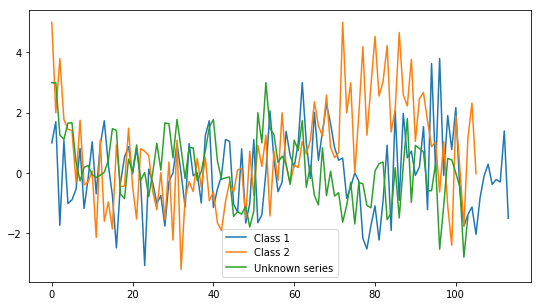

In [127]:
plt.figure(figsize=(9,5))
plt.plot(series_1, label="Class 1")
plt.plot(series_2, label="Class 2")
plt.plot(series_test, label="Unknown series")
plt.legend(loc='best')
plt.show()

In [128]:
prior_transition1 = np.ones((2, 2)) 
prior_params1 = {0: [1, 2, 1, 2],
                1: [1, 2, 1, 2]}
n_iter_gibbs = 10000

In [130]:
model_class1 = bayesian_hmm(prior_params1, prior_transition1, n_iter_gibbs, class_label=1)
%time model_class1.fit([(series_1, hidden_seq1)])

Model fitted
Wall time: 288 ms


In [131]:
prior_transition2 = np.ones((2, 2)) 
prior_params2 = {0: [1, 2, 1, 2],
                1: [1, 2, 1, 2]} 

In [132]:
model_class2 = bayesian_hmm(prior_params2, prior_transition2, n_iter_gibbs, class_label=2)
%time model_class2.fit([(series_2, hidden_seq2)])

Model fitted
Wall time: 275 ms


In [133]:
assign_classes([series_test], [model_class1, model_class2]) # correct answer 

[1]